# Implement Online portfolio algorithms directly into the Gyn environment

In [1]:
from stable_baselines3.common.type_aliases import GymEnv
from typing import Any, Dict, Optional, Tuple, Union, List

import numpy as np
import pandas as pd

import scipy.optimize as optimize


def optimize_log_returns(
    prices
):
    assert prices.notnull().all().all()

    x_0 = np.ones(prices.shape[1]) / float(prices.shape[1])
    
    # Using price returns here.
    objective = lambda b: -np.sum(np.log(np.maximum(np.dot(prices - 1, b) + 1, 0.0001)))

    cons = ({"type": "eq", "fun": lambda b: 1 - sum(b)},)

    # problem optimization
    res = optimize.minimize(
        objective,
        x_0,
        bounds=[(0.0, 1.0)] * len(x_0),
        constraints=cons,
        method="slsqp"
    )

    if res.success:
        return res.x
    raise ValueError("Could not find an optimal value using the BCRP algorithm.")


class SCRPModel:
    def __init__(
            self, 
            env: Union[GymEnv, str],
            policy: Any, # Policy doesnt matter here
            device: str, # device doesnt matter here
            policy_kwargs: Optional[Dict[str, Any]] = None, # policy_kwargs doesnt matter here
            price_history: Optional[pd.DataFrame] = None
            ) -> None:
        
        # Super simple algorithm, we only need the environment

        assert env is not None 
        self.env = env

        # Pull out the actions space dimensions for the portfolio
        self.action_space_shape = self.env.action_space.shape
        self.portfolio_length = self.action_space_shape[0]
        
        self.price_history = pd.DataFrame()

        # If available, set additional price history
        if price_history is not None:
            self.price_history = price_history

        # Start with uniform portfolio weights
        self.current_weights = np.ones(self.portfolio_length-1) / (self.portfolio_length-1)  # target weights for each asset
        # Append 0 to the beginning, for an empty cash account
        self.current_weights = np.insert(self.current_weights, 0, 0)

    def train(self) -> None:
        # This model is derministic and doesnt learn anything, it only predicts
        raise NotImplementedError("Can't use 'train' on a benchmark model, use predict instead. These models are deterministic.")

    def learn(
        self
    ):
        # This model is derministic and doesnt learn anything, it only predicts
        raise NotImplementedError("Can't use 'learn' on a benchmark model, use predict instead. These models are deterministic.")

    def predict(
        self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False, # This is always determininistic
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:

        # This comes from the policies class in stable baselines.
        # Use this to validate the environment.
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )
        
        # Reshape the array to remove single dimensions 
        reshaped_array = observation.reshape(len(self.env._features), self.portfolio_length - 1) 

        # This assumes the close prices are in the environment.
        # This will break if close prices are not first in the environment
        # TODO fix this
        prices = reshaped_array[0].tolist()

        new_row = pd.DataFrame([prices])

        # Add to the price history
        self.price_history = pd.concat([self.price_history, new_row], ignore_index=True)

        # Normalize the prices
        r = {}
        for name, s in self.price_history.items():
            init_val = s.loc[s.first_valid_index()]
            r[name] = s / init_val
        price_history = pd.DataFrame(r)

        if len(price_history) <= 1:
            action_weights = self.current_weights
            actions = action_weights.reshape(1, self.portfolio_length)
            return actions, None
        
        # Find the optimal portfolio over the window price history
        self.current_weights = np.array(optimize_log_returns(price_history))

        assert np.isclose(self.current_weights.sum(), 1), "The array does not sum up to one."

        # Use the last portfolio as the new action (keep it the same)
        action_weights = np.insert(self.current_weights, 0, 0)
        actions = action_weights.reshape(1, self.portfolio_length)

        return actions, None

KeyboardInterrupt: 

In [ ]:


MODELS = {"scrp": SCRPModel}

class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # TODO default to usethe MlpPolicy
        return model(env=self.env, policy="MlpPolicy", **model_kwargs)

    @staticmethod
    def train_model(model, env, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        model.learn(
            total_timesteps = max_steps * episodes # TODO fix this
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        

        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
           
            action, _states = model.predict(test_obs, deterministic=deterministic)

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

HISTORY_START_DATE = '2010-01-01'
HISTORY_END_DATE = '2024-10-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader


# # TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]

# STOCKS = [
#     "AAPL",
#     "MSFT",
#     "V",
# ]

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = HISTORY_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (114898, 8)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader


# # TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]

# STOCKS = [
#     "AAPL",
#     "MSFT",
#     "V",
# ]

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()


from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)


from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

environment = PortfolioOptimizationEnv(
        portfolio_norm_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

SCRP_results = {
    "date": {},
    "training": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_scrp.get_model("scrp")

values, dates = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

# Pull out the historical price data for SCRP
agent_scrp = DRLStableAgent(env = environment)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment)
SCRP_results["training"] = environment._terminal_asset_memory["final"]
SCRP_results["date"] = environment._terminal_date_memory



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (27289, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.44967348 0.30646708 0.48665761 0.34385037 0.32998065 0.31500104
 0.28853749 0.2781374  0.28311105 0.35018996 0.28479142 0.32734885
 0.37702692 0.3591673  0.49457685 0.30874429 0.4419601  0.44753717
 0.55705992 0.33337465 0.26140776 0.28204132 0.26416194 0.23752298
 0.22372669 0.24091322 0.22921621 0.2017071  0.18873202 0.252844
 0.30726287 0.303931   0.27509987 0.32608395 0.49665197 0.3484371
 0.46504188 0.51638148 0.36496779 0.32088908 0.35448204 0.55904059
 0.48251113 0.48442528 0.40644484 0.35127192 0.32329149 0.27646896
 0.28995804 0.36157881 0.35123834 0.38041213 0.58224413 0.35117464
 0.29957051 0.27780384 0.31016923 0.29519025 0.2536062  0.26883371
 0.37129358 0.23562547 0.27818259 0.25157313 0.26191391 0.27878947
 0.334777   0.28687093 0.286389

Initial portfolio value:1000000
Final portfolio value: 46415284.0
Final accumulative portfolio value: 46.415284
Maximum DrawDown: -0.4379718618190428
Sharpe ratio: 1.0033424547719105
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1839710.5
Final accumulative portfolio value: 1.8397105
Maximum DrawDown: -0.30907909345529416
Sharpe ratio: 0.7379224006861825
hit end!


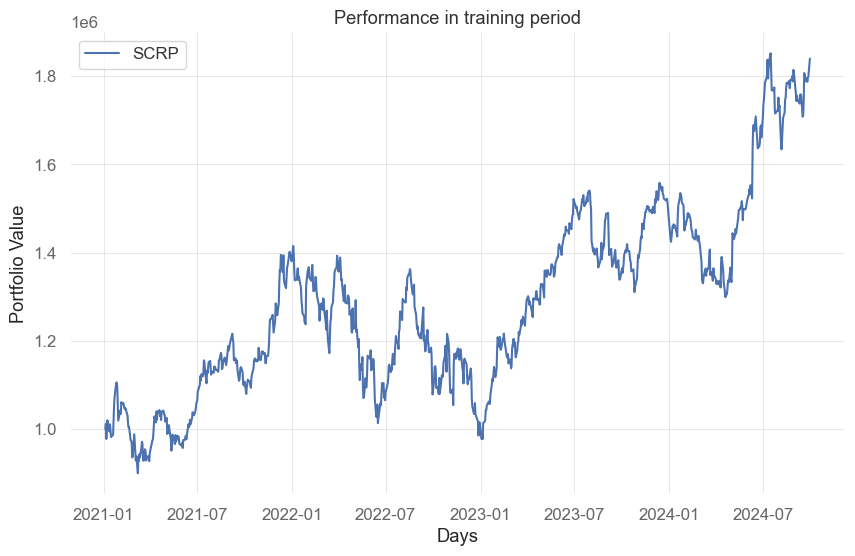

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(SCRP_results["date"], SCRP_results["training"], label="SCRP")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()